
## Introduction

The aim of this assignment is to give you the experience of using real public data and create your own report. The raw data are available in different formats and structures and often contain undesired formatting errors. Statistical data are continuously updated and may even provide API's to stream data instead of taking snapshots. We will be using snapshots in this assignment but to streamline the analysis around possible future snapshots you'll be implementing a 'data-specific' Python class with appropriate methods for data manipulation and visualisation.

**Note:** please direct your questions on this assignment to **r.monajemi@lumc.nl**

## Data: Emissions to air by the Dutch economy

In this assignment we will be using *Emissions to air by the Dutch economy* [CBS StatLine](https://opendata.cbs.nl/portal.html?_la=en&_catalog=CBS&tableId=83300ENG&_theme=1129) dataset. There you'll find the latest release of the dataset, however and older version will be provided via brightspace. Note that the results that shown below are produced using the old datasets: the metadata (`83300ENG_metadata.csv`) and the raw data (`83300ENG_UntypedDataSet_29032023_184145.csv`). 




## Assignment

#### 1) Class GWP [4p].

- Create the class `GWP` (Global Warming Potential) which is initialised with raw data along with the meta information.
- Create class attributes [emissions](emissions.md) and [emission_sources](emission_sources.md) from the metadata.
- Additional attributes:
    - `Date` :  of type timestamp created from the variable `Periods`
    - `Source` : holding the `Title` values of the emission source in the metadata.

In [302]:
## question 1
from datetime import datetime
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

class GWP:
    def __init__(self, path, meta_path):
        self._path = path
        self._meta_path = meta_path

        metadata_str = pd.read_csv(meta_path, sep=";")
        # the emissions_source data range from (4, 25)
        emission = pd.DataFrame(columns=['', 'Title', 'Description', 'Unit'])
        for i in range(6, 25):
            # if first variable is NaN, remove the row
            if pd.isna(metadata_str.index[i][4]):
                continue 
            emission.loc[len(emission)] = [metadata_str.index[i][4], 
                                            metadata_str.index[i][5], 
                                            metadata_str.index[i][6], 
                                            metadata_str.index[i][-11]]
        self.emission = emission

        # the emission_source data range from (27, 86)
        emission_source = pd.DataFrame(columns=['DutchEconomy', 'Title', 'Description'])
        for i in range(27, 86):
            # all data in index, get the corresponding column from the index
            emission_source.loc[len(emission_source)] = [metadata_str.index[i][0], 
                                                        metadata_str.index[i][1], 
                                                        metadata_str.index[i][2]]
        self.emission_sources = emission_source
        # load the data
        self.data = pd.read_csv(path, sep=";")
        # add Date to data
        self.data["Date"] = pd.to_datetime(self.data["Periods"].str[:4] + "-" + "01" + "-" + "01")
        # add Source to data
        data_selected = self.emission_sources.loc[:, ['DutchEconomy', 'Title']]
        data_selected.rename(columns={"Title": "Source"}, inplace=True)
        self.data = pd.merge(self.data, data_selected, on = 'DutchEconomy', how = 'left')
## question 2
        self.data['N2O_4'] = self.data['N2O_4'] * 298
        self.data['CH4_5'] = self.data['CH4_5'] * 25
        self.data["HFC"] = self.data.apply(lambda x: x['TotalCO2_1'] + x['N2O_4'] + x['CH4_5'] - x['GreenhouseGasEquivalents_6'], axis=1)
## question 3
    def plot(self, emission, source):
        label = []
        # get the labels of source
        for i in range(len(source)):
            filtered_df = pd.DataFrame(columns=['DutchEconomy', 'Title', 'Description'])
            for k in range(len(self.emission_sources.index)):
                # match source[i] in descriptions and ignore the capital
                match_1 = source[i] in self.emission_sources.iloc[k]['Description'].lower().split() 
                match_2 = source[i] in self.emission_sources.iloc[k]['DutchEconomy'].lower().split()
                if match_1 or match_2:
                    filtered_df.loc[len(filtered_df.index)] = self.emission_sources.loc[k]
            for j in range(len(filtered_df.index)):
                label.append(filtered_df.iloc[j]["Title"])
        # melt the selected data
        select = self.data[self.data['Source'].isin(label)]
        select_long = pd.melt(frame=select, id_vars=['ID', 'Date', 'Source'], value_vars=emission, var_name='Emission', value_name='Value')
        # plot with seaborn
        sns.set_theme()
        sns.lineplot(data = select_long, x="Date", y="Value", hue="Source", style="Emission")
        legend = plt.legend(bbox_to_anchor=(1, 0.6), loc='upper left')
        frame = legend.get_frame()
        frame.set_color('none')
        frame.set_linewidth(0)
        plt.xlabel("Year")
        plt.ylabel("Emission (MCM)")
## question 4
    def get_emission(self, key):
        emission_map = {"ghg": ["TotalCO2_1", "CO2ExclBiomass_2", "CO2Biomass_3", "N2O_4", "CH4_5", "GreenhouseGasEquivalents_6", "HFC"], 
                        "acid": ["NOx_7", "SO2_8", "NH3_9", "AcidificationEquivalents_10"], 
                        "ozone": ["CFK12Equivalents_11"], 
                        "air": ["CO_12", "NMVOC_13", "PM10_14"]}
        if key not in emission_map:
            raise ValueError( f"'{key}' is not a valid emission category!" )
        return emission_map.get(key)
## question 5
    def summary(self, date=None):
        if date == None:
            print(f"Data path: '{self._path}'. Meta_data path: '{self._meta_path}'")
            print(f"Shape of data: '{self.data.shape}'")
            print(f"Number of emission sources: '{len(self.emission_sources)}'")
            print(f"Number of emission variables: 14")
            print(f"First date: '{self.data['Date'].min()}'. Latest date: '{self.data['Date'].max()}'")
        else:
            mindate = datetime.strptime(date[0], '%Y-%m-%d')
            maxdate = mindate
            if date[1] != "":
                maxdate = datetime.strptime(date[1], '%Y-%m-%d')

            dataselected = self.data.loc[(self.data['Date'] >= mindate) & (self.data['Date'] <= maxdate)]
            index_list = dataselected.columns.tolist()[3:-3]
            columns_list = ["min", "1st quartile", "2nd quartile", "mean 3rd quartile", "max"]
            summ = pd.DataFrame(index = index_list, columns = columns_list)

            for col in index_list:
                summ.loc[col, columns_list[0]] = dataselected[col].min()
                summ.loc[col, columns_list[1]] = dataselected[col].quantile(0.25)
                summ.loc[col, columns_list[2]] = dataselected[col].quantile(0.5)
                summ.loc[col, columns_list[3]] = dataselected[col].quantile(0.75)
                summ.loc[col, columns_list[4]] = dataselected[col].max()
            print(summ)
## question 6
    def violin(self, emission, source):
        label = []
        # get the labels of source
        for i in range(len(source)):
            filtered_df = pd.DataFrame(columns=['DutchEconomy', 'Title', 'Description'])
            for k in range(len(self.emission_sources.index)):
                # match source[i] in descriptions and ignore the capital
                match_1 = source[i] in self.emission_sources.iloc[k]['Description'].lower().split() 
                match_2 = source[i] in self.emission_sources.iloc[k]['DutchEconomy'].lower().split()
                if match_1 or match_2:
                    filtered_df.loc[len(filtered_df.index)] = self.emission_sources.loc[k]
            for j in range(len(filtered_df.index)):
                label.append(filtered_df.iloc[j]["Title"])
        select = self.data[self.data['Source'].isin(label)]
        fig, axes = plt.subplots(math.ceil(len(emission)/2),2)
        for i in range(len(emission)):
            sns.violinplot(data=select,y=select[emission[i]], hue="Source", ax=axes[i], legend = "auto")

In [303]:
gwp = GWP(path="data/83300ENG_UntypedDataSet_29032023_184145.csv", meta_path='data/83300ENG_metadata.csv')

In [261]:
gwp.emission.head()

,,Title,Description,Unit
0,TotalCO2_1,Total CO2,Carbon dioxide.\nGreenhouse gas (causes the te...,mln kgs
1,CO2ExclBiomass_2,CO2 excl. biomass,Carbon dioxide.excluding emissions from biomas...,mln kgs
2,CO2Biomass_3,CO2 biomass,Carbon dioxide.emissions from biomass.\nGreenh...,mln kgs
3,N2O_4,N2O,Laughing gas/dinitrogen oxide.\nN2O is formed ...,mln kgs
4,CH4_5,CH4,Methane (= natural gas).\nAmong other causes C...,mln kgs


In [262]:
gwp.emission_sources.head()

,DutchEconomy,Title,Description
0,1050010,Total private households,Private households:\nA private household gathe...
1,B000579,Total Dutch economy,"This includes emissions from households, from ..."
2,B000580,Transport activity by private households,Air emissions caused by transportation activit...
3,B000581,Other private households,Emissions to air caused by other activities of...
4,T001081,A-U All economic activities,All economic activities


In [263]:
gwp.data.dtypes

ID                                      int64
DutchEconomy                           object
Periods                                object
TotalCO2_1                              int64
CO2ExclBiomass_2                        int64
CO2Biomass_3                          float64
N2O_4                                 float64
CH4_5                                 float64
GreenhouseGasEquivalents_6              int64
NOx_7                                 float64
SO2_8                                 float64
NH3_9                                 float64
AcidificationEquivalents_10           float64
CFK12Equivalents_11                   float64
CO_12                                 float64
NMVOC_13                              float64
PM10_14                               float64
Date                           datetime64[ns]
Source                                 object
HFC                                   float64
dtype: object

#### 2) Greenhouse equivalents [1p].

The [greenhouse equivalents](https://www.cbs.nl/en-gb/news/2020/19/uitstoot-broeikasgassen-3-procent-lager-in-2019/co2-equivalents) is a measure to relate othe other gases to CO2.

- Convert `N2O_4` and `CH4_5` in `GWP.data` to CO2 equivalents.
- Add a new variable `HFC` to the GWP.data which contains the fluorine (chlorine) gases CO2 equivalents. HFC stands for hydrofluorocarbons (see [Fluorinated gases](https://en.wikipedia.org/wiki/Fluorinated_gases)). The emission has been added to the total greenhouse gas equivalent but not specified as separate variable. See also *greenhouse gas equivalents* description in the metadata.

#### 3) Implement a plot method that produces the figure below. [3p]

**Synopsis:** &nbsp; &nbsp;**<tt>GWP.plot(emission, source)</tt>**

    - emission: is a list of emissions to be drawn
    - source: list of Dutch economy sector id's or a pattern

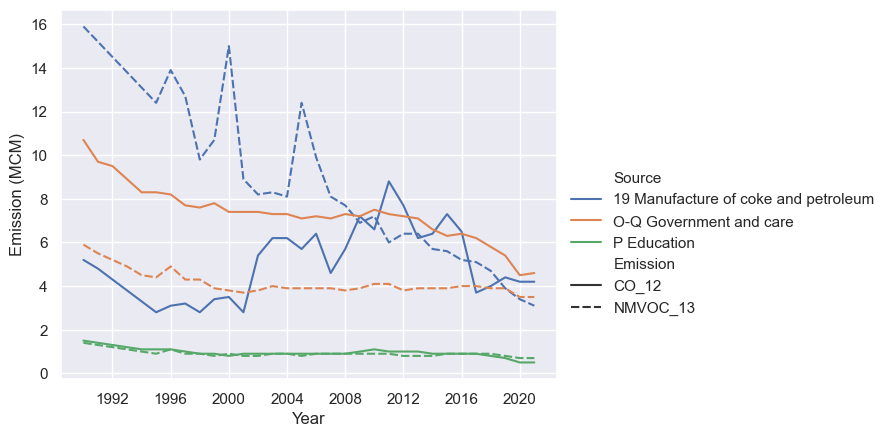

In [274]:
gwp.plot(emission=['CO_12', 'NMVOC_13'],source=['education', 'government','320000' ]);


#### 4) Emission categories [1p]

There are 4 categories of emissions:
   - Greenhouse gases (climate change) {TotalCO2_1, CO2ExclBiomass_2, CO2Biomass_3, N2O_4, CH4_5, GreenhouseGasEquivalents_6}
   - Acidification {NOx_7, SO2_8, NH3_9, AcidificationEquivalents_10}
   - Ozone layer depletion {CFK12Equivalents_11}
   - Other air pollution {CO_12, NMVOC_13, PM10_14, HFC}

Implement the method `get_emission` with the following specification:

**Synopsis:** &nbsp; &nbsp;**<tt>GWP.get_emission(emission_category)</tt>**

   - emission_category : {ghg, acid, ozone, air}
   - return value : list of variable names of the given category.


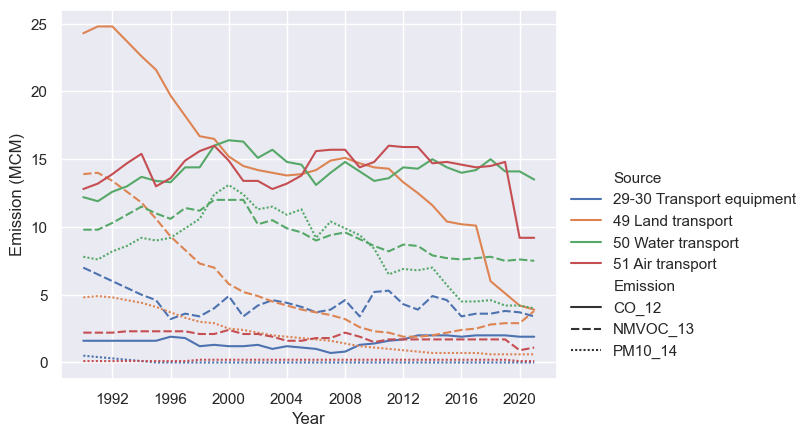

In [272]:
gwp.plot(emission=gwp.get_emission('air'),source=['transport']);

#### 5) Summary [1p]

Implement the `summary` method which gives `general information` about the data such as:
- data and meta file paths
- shape of the data
- number of emission sources.
- number of emission variables
- first and latest date


**Synopsis:** &nbsp; &nbsp;**<tt>GWP.summary(date)</tt>**
   - `date`     : tuple of dates (min,[max]).

If `date` is given then print a DataFrame of descriptive statistics with columns {min, 1st quartile, 2nd quartile, mean 3rd quartile, max} and emission as row indices. In this case do not output the `general information`. Note, for the `date` method argument, in case 'max' is omitted then the summary is given for a single year.


In [266]:
# test example
date1 = ("2013-01-01", "2020-01-01")
date2 = ("2013-01-01", "")
print(gwp.summary(date1))
# print(gwp.summary(date2))
print(gwp.summary())


                             min 1st quartile 2nd quartile mean 3rd quartile  \
TotalCO2_1                     0       339.25       1589.5            9891.5   
CO2ExclBiomass_2               0        304.0       1420.0            8987.5   
CO2Biomass_3                 0.0         2.75        20.45           386.075   
N2O_4                        0.0          0.0          0.0              89.4   
CH4_5                        0.0          2.5         6.25            80.625   
GreenhouseGasEquivalents_6     0        365.5       1819.0           10189.0   
NOx_7                        0.0          0.5         3.25            10.475   
SO2_8                        0.0          0.0          0.1               1.6   
NH3_9                        0.0          0.0          0.0               0.4   
AcidificationEquivalents_10  0.0          0.0          0.1               0.4   
CFK12Equivalents_11          0.0          0.0          0.0               0.0   
CO_12                        0.0        

#### 6) Bonus point

Add a new plot method to the class which gives a different kind of information than the one given in GWP.plot.

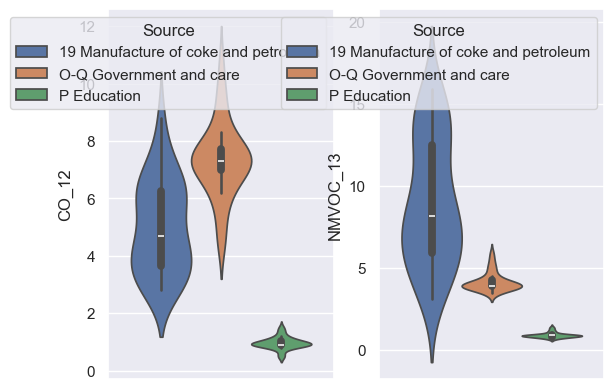

In [304]:
## Answer Explaination:
## For this function, I use the violin plot to observe the distribution of emissions with each Source. And the input of 
## the function is the same as that in Question 3, an emission list and a source list. The output of the function is a group
## of violin plot, and the layout is (n, 2).
 
# test example for violin plot
gwp.violin(emission=['CO_12', 'NMVOC_13'],source=['education', 'government','320000' ]);